# FINTECH BOOTCAMP - PROJECT 2
## Group 2 Notebook
---
By applying machine learning models, we examine (1) if selective technical indicators could predict the stock direction with statistically significant level (2) Which model is the best (3) Whether we could optimize the model (4) Which time frame the model could generate the best result. 

In [44]:
# Initial import all libraries and dependencies
import yfinance as yf
import matplotlib.dates as mdates
import panel as pn
import datetime
import numpy as np
import pandas as pd
import hvplot.pandas
from finta import TA
# from pandas_datareader import data
import matplotlib.pyplot as plt

# Ignore wanrings
import warnings
warnings.filterwarnings("ignore")


# Machine learning libraries
from sklearn.preprocessing import StandardScaler

### I. DATA FETCHING AND CLEANING

In [45]:
# Define the instruments to download data of a stock/ETF .
tickers = ["AAPL", "TSLA", "MSFT", "SPY", "..."] # to be decided

# Fetch SPY Data from 1/1/2017 until 12/31/2021 and choosing a interval
start_date = datetime.date(2017,1,1)
end_date = datetime.date(2021,12,31)
interval = '1d'

In [46]:
#Use pandas_reader.data.DataReader to load the desired data.
yf.Tickers(tickers[0])
panel_data = yf.download(tickers[0], start = start_date, end = end_date, interval = interval)

# Checkout the data type
type(panel_data)

[*********************100%***********************]  1 of 1 completed


pandas.core.frame.DataFrame

In [47]:
# Review data
panel_data.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-23,175.850006,176.850006,175.270004,176.279999,176.055695,68356600
2021-12-27,177.089996,180.419998,177.070007,180.330002,180.100540,74919600
2021-12-28,180.160004,181.330002,178.529999,179.289993,179.061859,79144300
2021-12-29,179.330002,180.630005,178.139999,179.380005,179.151749,62348900
2021-12-30,179.470001,180.570007,178.089996,178.199997,177.973251,59773000


In [48]:
# Data description and check if null
def data_description(df):
    print("Data Information")
    print(df.info())
    print("-"*50)

In [49]:
data_description(panel_data) # if 0 null and OHLC is floating and Volumne is int, then data is clean to proceed to part II

Data Information
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2017-01-03 to 2021-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1258 non-null   float64
 1   High       1258 non-null   float64
 2   Low        1258 non-null   float64
 3   Close      1258 non-null   float64
 4   Adj Close  1258 non-null   float64
 5   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.8 KB
None
--------------------------------------------------


In [50]:
# IF data is not clean then dropping null or convert datatype
# def data_cleaning(df):
#     df.dropna()

In [51]:
# Convert to ohlcv dataframe to be ready for finta
def ohlcv(df):
    del(df['Close'])
    df = df.rename(columns = {"Open": "open",'High' : 'high', 'Low' : "low", "Adj Close": "close", 'Volume': 'volume'},inplace = True)
    return df

In [52]:
ohlcv(panel_data)
panel_data

,open,high,low,close,volume
Date,,,,,
2017-01-03,28.950001,29.082500,28.690001,27.297689,115127600
2017-01-04,28.962500,29.127501,28.937500,27.267138,84472400
2017-01-05,28.980000,29.215000,28.952499,27.405804,88774400
2017-01-06,29.195000,29.540001,29.117500,27.711327,127007600
2017-01-09,29.487499,29.857500,29.485001,27.965147,134247600
...,...,...,...,...,...
2021-12-23,175.850006,176.850006,175.270004,176.055695,68356600
2021-12-27,177.089996,180.419998,177.070007,180.100540,74919600
2021-12-28,180.160004,181.330002,178.529999,179.061859,79144300


### II. DATA PROCESSING AND PREPARATION

In [53]:
# Timeframe for prediction
time_frame = [3,5,7]

# Identify stock direction
def stock_direction(df, days):# days is time frame
    direction = (df['close'].shift(-days) > df['close'])
    direction = direction.iloc[:-days]
    return direction.astype(int) #return y values

In [54]:
stock_direction(panel_data,time_frame[0]) # y values

Date
2017-01-03    1
2017-01-04    1
2017-01-05    1
2017-01-06    1
2017-01-09    1
             ..
2021-12-20    1
2021-12-21    1
2021-12-22    1
2021-12-23    1
2021-12-27    0
Name: close, Length: 1255, dtype: int32

In [55]:
# Using Finta calculate technical indicators
# Define key window to calculate for technical analysis 
window = [5,14,21,50]
def technical_indicators (df): # https://github.com/peerchemist/finta/blob/master/finta/finta.py
    x = pd.DataFrame()
    for n in range(len(window)) :  ### LOOPING DOES NOT SHOW(?)
        a = TA.BBANDS(df,window[n])
        a = a.add_prefix(f"{window[n]}_")
        b = TA.RSI(df,window[n])
        c = TA.PIVOT_FIB(df)
        c = c.add_prefix(f"{window[n]}_")
        d = TA.OBV(df)
        d.rename(f"{window[n]}_OBV", axis = 1, inplace = True)
        e = TA.SMA(df,window[n])
        f = TA.EMA(df,window[n])
        g = TA.ROC(df,window[n])
        g.rename(f"{window[n]}_ROC", axis = 1, inplace = True)
        k = TA.WILLIAMS(df,window[n])
        temp = pd.concat([a,b,c,d,e,f,g,k],axis = 1)
        x = pd.concat([x,temp],axis=1)
    return x

In [56]:
technical_indicators(panel_data)

,5_BB_UPPER,5_BB_MIDDLE,5_BB_LOWER,5 period RSI,5_pivot,5_s1,5_s2,5_s3,5_s4,5_r1,...,50_s4,50_r1,50_r2,50_r3,50_r4,50_OBV,50 period SMA,50 period EMA,50_ROC,50 Williams %R
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.297689,NaN,NaN
2017-01-04,NaN,NaN,NaN,0.000000,28.356730,28.206795,28.114165,27.964230,27.814295,28.506665,...,27.814295,28.506665,28.599295,28.749230,28.899165,-8.447240e+07,NaN,27.282108,NaN,NaN
2017-01-05,NaN,NaN,NaN,85.015097,28.444046,28.371466,28.326626,28.254045,28.181465,28.516626,...,28.181465,28.516626,28.561466,28.634047,28.706627,4.302000e+06,NaN,27.325000,NaN,NaN
2017-01-06,NaN,NaN,NaN,95.515409,28.524434,28.424159,28.362209,28.261934,28.161658,28.624710,...,28.161658,28.624710,28.686660,28.786935,28.887210,1.313096e+08,NaN,27.427452,NaN,NaN
2017-01-09,28.130021,27.529421,26.928821,97.404272,28.789609,28.628214,28.528504,28.367109,28.205713,28.951005,...,28.205713,28.951005,29.050715,29.212110,29.373505,2.655572e+08,NaN,27.543763,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,178.555870,172.939664,167.323457,63.064880,174.475499,173.058277,172.182715,170.765493,169.348270,175.892722,...,169.348270,175.892722,176.768284,178.185506,179.602729,6.060665e+09,158.594117,161.579138,25.283713,-14.953985
2021-12-27,182.643087,174.775323,166.907560,73.632224,176.058568,175.455008,175.082127,174.478566,173.875006,176.662129,...,173.875006,176.662129,177.035009,177.638570,178.242131,6.135585e+09,159.328771,162.305468,25.621307,-5.207762
2021-12-28,182.567197,176.680896,170.794595,67.438857,179.196849,177.917152,177.126554,175.846858,174.567161,180.476545,...,174.567161,180.476545,181.267143,182.546839,183.826536,6.056440e+09,160.021110,162.962581,23.965524,-7.873096


In [57]:
def consol_data(df,days):
    consol_data = technical_indicators(df)
    consol_data["direction"] = stock_direction(df,days)
    consol_data.dropna(inplace = True)
    return consol_data

In [58]:
data = consol_data(panel_data,time_frame[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1203 entries, 2017-03-16 to 2021-12-27
Data columns (total 73 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   5_BB_UPPER      1203 non-null   float64
 1   5_BB_MIDDLE     1203 non-null   float64
 2   5_BB_LOWER      1203 non-null   float64
 3   5 period RSI    1203 non-null   float64
 4   5_pivot         1203 non-null   float64
 5   5_s1            1203 non-null   float64
 6   5_s2            1203 non-null   float64
 7   5_s3            1203 non-null   float64
 8   5_s4            1203 non-null   float64
 9   5_r1            1203 non-null   float64
 10  5_r2            1203 non-null   float64
 11  5_r3            1203 non-null   float64
 12  5_r4            1203 non-null   float64
 13  5_OBV           1203 non-null   float64
 14  5 period SMA    1203 non-null   float64
 15  5 period EMA    1203 non-null   float64
 16  5_ROC           1203 non-null   float64
 17  5 Williams %R  

Encoding data

In [59]:
# Create our features
X = data.copy()
X.drop("direction", axis = 1, inplace = True)
X.head()

,5_BB_UPPER,5_BB_MIDDLE,5_BB_LOWER,5 period RSI,5_pivot,5_s1,5_s2,5_s3,5_s4,5_r1,...,50_s4,50_r1,50_r2,50_r3,50_r4,50_OBV,50 period SMA,50 period EMA,50_ROC,50 Williams %R
Date,,,,,,,,,,,,,,,,,,,,,
2017-03-16,33.356297,32.973840,32.591384,79.087478,34.366394,34.202134,34.100654,33.936394,33.772134,34.530654,...,33.772134,34.530654,34.632134,34.796394,34.960654,2.059894e+09,30.572748,31.583612,21.653013,-32.394760
2017-03-17,33.368670,33.013967,32.659264,59.714389,34.509487,34.436906,34.392066,34.319485,34.246904,34.582068,...,34.246904,34.582068,34.626909,34.699490,34.772071,1.884354e+09,30.688270,31.649022,21.183369,-35.093450
2017-03-20,33.551643,33.120657,32.689670,75.480739,34.421912,34.315907,34.250417,34.144412,34.038407,34.527917,...,34.038407,34.527917,34.593407,34.699412,34.805417,1.970522e+09,30.807958,31.726615,21.836285,-31.718531
2017-03-21,33.464374,33.160785,32.857196,49.041427,34.607571,34.486285,34.411355,34.290070,34.168784,34.728856,...,34.168784,34.728856,34.803786,34.925072,35.046357,1.812402e+09,30.913888,31.783406,19.113141,-43.317283
2017-03-22,33.567002,33.206103,32.845203,64.290662,34.546777,34.253591,34.072461,33.779275,33.486090,34.839963,...,33.486090,34.839963,35.021093,35.314279,35.607465,1.915843e+09,31.022200,31.853851,19.365622,-37.726373


In [60]:
# Create our target
y = data["direction"].copy()
y.values.reshape(-1,1)

array([[0.],
       [1.],
       [0.],
       ...,
       [1.],
       [1.],
       [0.]])

In [61]:
# Checkout the balance of our target values
y.value_counts() # It's not that imbalance, ok to proceed further

1.0    710
0.0    493
Name: direction, dtype: int64

Split the data into Training and Testing

In [62]:
# Split the X and y into X_train, X_test, y_train, y_test
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

Scale the training and testing 

In [63]:
# Create the StandardScaler instance
scaler = StandardScaler()
# Fit the Standard Scaler with the training data
# # Scale the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### III. CHOOSING MODELS AND TRAINING MODEL

#### 1. Model 1. Random Forest Classifier

Import dependent libraries

In [64]:
# library for 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc

In [65]:
rf_model = RandomForestClassifier(n_estimators = 250, random_state = 42)
rf_model = rf_model.fit(X_train_scaled,y_train)
y_train_pred = rf_model.predict(X_train_scaled)
y_pred = rf_model.predict(X_test_scaled)
print(f"Accuracy_score is {accuracy_score(y_test,y_pred)}")
print("-"*50)
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))
print("-"*50)
print("Classification Report")
print(classification_report(y_test, y_pred))

Accuracy_score is 0.43213296398891965
--------------------------------------------------
Confusion Matrix
[[156   0]
 [205   0]]
--------------------------------------------------
Classification Report
              precision    recall  f1-score   support

         0.0       0.43      1.00      0.60       156
         1.0       0.00      0.00      0.00       205

    accuracy                           0.43       361
   macro avg       0.22      0.50      0.30       361
weighted avg       0.19      0.43      0.26       361



In [66]:
# Plot ROC for Random Forest Classifier
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred,pos_label=1)
auc_train = auc(fpr_train, tpr_train)
auc_train = round(auc_train, 4)
#fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred,pos_label=1)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred)
auc_test = auc(fpr_test, tpr_test)
auc_test = round(auc_test, 4)

# Create a DataFrame with the fpr and tpr results
roc_df_train = pd.DataFrame({"FPR": fpr_train, "TPR": tpr_train,})
roc_df_test = pd.DataFrame({"FPR": fpr_test, "TPR": tpr_test})

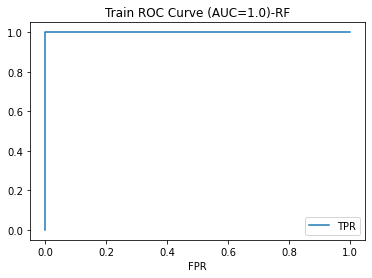

In [67]:
# Plot roc train
plot_train = roc_df_train.plot(
    x="FPR",
    y="TPR",
    xlim=([-0.05, 1.05]),
    title=f"Train ROC Curve (AUC={auc_train})-RF",
)

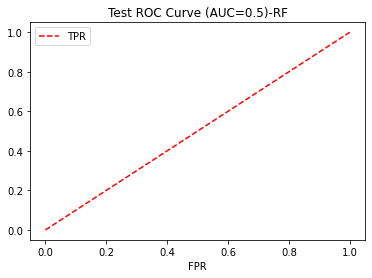

In [68]:
plot_test = roc_df_test.plot(
    x="FPR",
    y="TPR",
    color="red",
    style="--",
    xlim=([-0.05, 1.05]),
    title=f"Test ROC Curve (AUC={auc_test})-RF",
)

In [69]:
# List the features sorted in descending order by feature importance
importances = rf_model.feature_importances_
df_importances = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse= True))
df_importances

,0,1
0,0.030967,14_ROC
1,0.029641,21 Williams %R
2,0.029580,21_ROC
3,0.029245,14 period RSI
4,0.027780,5 period RSI
...,...,...
67,0.006411,21_pivot
68,0.006328,5_s1
69,0.006294,5_r1
70,0.006292,5_r2


In [70]:
# Define the variable importance plot
def variable_importance(df):
    plot = df.hvplot.barh("1", stacked=True, height=1200)
    return plot

In [71]:
# Plot the importance level 
variable_importance(df_importances)

:Bars   [1]   (0)

#### 2. Model 2......

In [72]:
#Using logistic Regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', random_state=42)
model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

In [73]:
#Calculate accuracy score
y_pred_2 = model.predict(X_test_scaled)
print(accuracy_score(y_test, y_pred_2))



0.5512465373961218


In [74]:
#Display confusion matrix
confusion_matrix(y_test, y_pred_2)

array([[ 23, 133],
       [ 29, 176]], dtype=int64)

In [75]:
#Print classification report
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

         0.0       0.44      0.15      0.22       156
         1.0       0.57      0.86      0.68       205

    accuracy                           0.55       361
   macro avg       0.51      0.50      0.45       361
weighted avg       0.51      0.55      0.48       361



In [76]:
#Using Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

In [77]:
#choosing learning rates
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    model_2 = GradientBoostingClassifier(
        n_estimators=10,
        learning_rate=learning_rate,
        max_features='log2',
        max_depth=2,
        random_state=42)
    model_2.fit(X_train_scaled, y_train.ravel())
    print('Learning Rate: ', learning_rate)

    #Score the model
    print("Accuracy score (training): {0:.3f}".format(
        model_2.score(
            X_train_scaled,
            y_train.ravel())))
    print("Accuracy score (validation): {0:.3f}".format(
        model_2.score(
            X_test_scaled,
            y_test.ravel())))
    print()

Learning Rate:  0.05
Accuracy score (training): 0.608
Accuracy score (validation): 0.507

Learning Rate:  0.1
Accuracy score (training): 0.615
Accuracy score (validation): 0.515

Learning Rate:  0.25
Accuracy score (training): 0.654
Accuracy score (validation): 0.468

Learning Rate:  0.5
Accuracy score (training): 0.701
Accuracy score (validation): 0.440

Learning Rate:  0.75
Accuracy score (training): 0.733
Accuracy score (validation): 0.435

Learning Rate:  1
Accuracy score (training): 0.752
Accuracy score (validation): 0.438



In [78]:
#building the model using grading boosting classifier
model_2 = GradientBoostingClassifier(
    n_estimators=10,
    learning_rate=0.1,
    max_features='log2',
    max_depth=2,
    random_state=42,
    verbose=True)
#fitting the model
model_2.fit(X_train_scaled, y_train.ravel())

      Iter       Train Loss   Remaining Time 
         1           1.3389            0.02s
         2           1.3338            0.02s
         3           1.3294            0.02s
         4           1.3255            0.01s
         5           1.3203            0.01s
         6           1.3155            0.01s
         7           1.3124            0.01s
         8           1.3071            0.00s
         9           1.3046            0.00s
        10           1.2987            0.00s


GradientBoostingClassifier(max_depth=2, max_features='log2', n_estimators=10,
                           random_state=42, verbose=True)

In [79]:
#Make predictions
predictions =model_2.predict(X_test_scaled)

#Generating accuracy score
accuracy_score(y_test, predictions)

0.5152354570637119

In [82]:
#Evaluating the model using confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1']
)
display(cm_df)

,Predicted 0,Predicted 1
Actual 0,113,43
Actual 1,132,73


In [81]:
#Generating classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.46      0.72      0.56       156
         1.0       0.63      0.36      0.45       205

    accuracy                           0.52       361
   macro avg       0.55      0.54      0.51       361
weighted avg       0.56      0.52      0.50       361



#### 3. Model 3......

#### 4. Model 4......

#### 5. Model 5 ......

### IV. ANALYSIS AND EVALUATION (TEAM WORK)

### V. DEPLOYING MODEL (TEAM WORK)

### VI. CONCLUSION (TEAM WORK)